# Determining the Age of Customers

<b>Aim</b>

To build a model that can estimate a customer's approximate age from a photograph.

<br><b>Background</b>

The chain supermarket "Bread-Salt" is implementing a computer vision system to process photos of customers. Photo capturing at the checkout area will help determine the age of clients in order to:

- Analyze purchases and suggest products that may interest buyers of that age group.;
- Monitor the honesty of cashiers when selling alcohol.

<br><b>Project Execution Plan</b>

Instructions for project completion:

- Conduct an exploratory analysis of the photo set.
- Prepare the data for training.
- Train a neural network and calculate its accuracy.

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


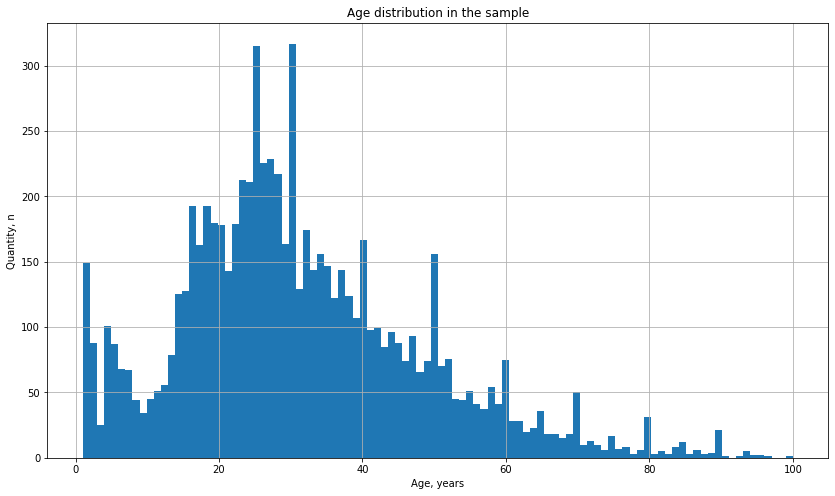

In [7]:
labels.hist(bins=100, figsize=(14,8))
plt.title('Age distribution in the sample')
plt.xlabel('Age, years')
plt.ylabel('Quantity, n')
plt.show()

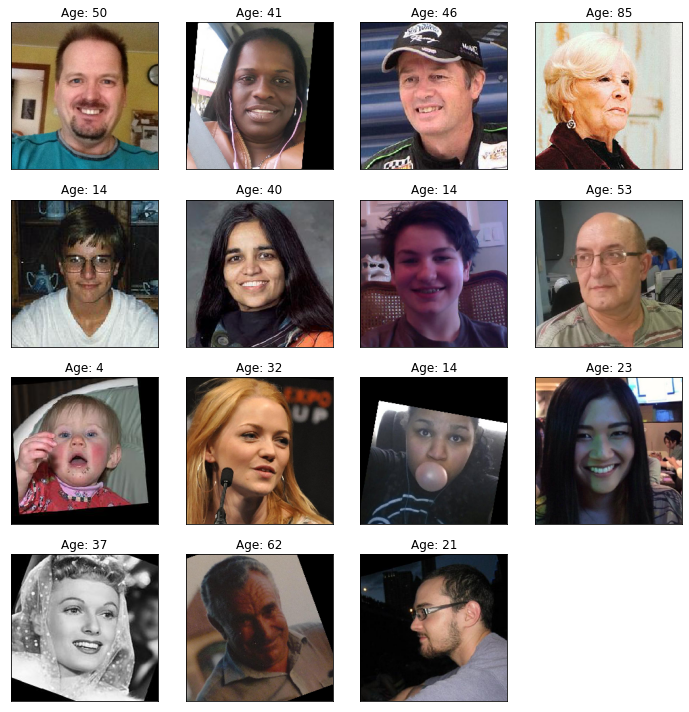

In [8]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Conclusions:</b>

The database contains 7.5 thousand photographs. The interquartile range of age is from 20 to 41 years with a median of 29 years.
This dataset is not perfect for training a model because:
- There are relatively few photographs.
- Some photos are of low quality.
- In some photos, people are not facing forward but are in profile.
- There are additional objects besides faces (a face may be covered by a hand, phone, gum, etc.).

All of this can reduce the age determination accuracy of the trained model.

## Model Training and Results

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    datagen_train = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True)
    datagen_train_flow = datagen_train.flow_from_dataframe(dataframe=labels,
      directory=path+'final_files/', 
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)
    return datagen_train_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    datagen_test = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    datagen_test_flow = datagen_test.flow_from_dataframe(dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return datagen_test_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-05-16 09:03:32.143988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-16 09:03:32.477613: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 62s - loss: 203.0221 - mae: 10.4075 - val_loss: 743.3980 - val_mae: 22.3296
Epoch 2/10
356/356 - 54s - loss: 81.2141 - mae: 6.8603 - val_loss: 126.9686 - val_mae: 8.5007
Epoch 3/10
356/356 - 53s - loss: 57.5393 - mae: 5.7648 - val_loss: 92.4329 - val_mae: 7.0298
Epoch 4/10
356/356 - 47s - loss: 44.1287 - mae: 5.0689 - val_loss: 95.6120 - val_mae: 7.4867
Epoch 5/10
356/356 - 55s - loss: 35.0813 - mae: 4.5327 - val_loss: 66.9526 - val_mae: 6.0563
Epoch 6/10
356/356 - 55s - loss: 25.7716 - mae: 3.9421 - val_loss: 68.4391 - val_mae: 6.1091
Epoch 7/10
356/356 - 45s - loss: 20.7765 - mae: 3.4606 - val_loss: 65.6749 - val_mae: 6.0410
Epoch 8/10
356/356 - 53s - loss: 17.2540 - mae: 3.1873 - val_loss: 68.8748 - val_mae: 6.2924
Epoch 9/10
356/356 - 54s - loss: 16.7551 - mae: 3.1123 - val_loss: 66.3551 - val_mae: 5.9823
Epoch 10/10
356/356 - 50s - loss: 13.4326 - mae: 2.8069 - val_loss: 71.5959 - val_mae: 6.5119
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 71.5959 - mae: 6.5119
Test MAE: 6.5119
```

## Analysis of the Trained Model

Our goal was to train a model that predicts the customer's age from a photograph using either MAE or MSE loss functions. Meanwhile, the Mean Absolute Error (MAE) should be no more than 7.

The provided dataset contains around 7,500 photographs of people. The photos vary in quality, the faces in the photos can be in different positions, and they can also be partially obscured by various foreign objects, making the model's training less precise.

The foundation of our model is a pre-trained neural network with a ResNet50 architecture. We chose 10 training epochs and the Adam algorithm with lr = 0.0001 for more precise training. When trained on the training dataset, the MAE was 2.8069, and on the test dataset, it was 6.5119, which is below 7.

Therefore, the task set before us has been accomplished.